# Liquid surface

Detailed here is the reduction of reflectometry from a liquid surface, such that the sample surface is horizontally oriented and the I07 double crystal deflector system is used to position the X-ray beam.
Here, we show the reduction of reflectometry collected from a water-surface in air. 

The first task is to enure that the necessary modules and packages have been imported.

In [86]:
# islatu is the data reduction pacakge
from islatu import io, refl_data, image, cropping, background
from scipy.interpolate import splrep
from PIL import Image
from uncertainties import unumpy as unp
from uncertainties import ufloat
import matplotlib.pyplot as plt

Once everything has been imported, we must set up the DCD q-dependent normalisation, this is due to slight deviations in the DCD crystals that lead to changes in the incident radiation intensity. 
The normalisation curve should have been collected during your beamtime, the `.dat` file that contains this curve should be assigned below.

In [2]:
normalisation_file = 'qdcd_norm.dat'

The file is read using the `islatu.io.i07_dat_parser` function and the data and associated metadata are returned. 

In [3]:
metadata_norm, data_norm = io.i07_dat_parser(normalisation_file)

It is possible to quickly observe the shape of the normalisation, by plotting. 
The x-axis ($q$) data is in the `'qdcd_'` object, while the intensity variation is typically stored in the `'adc2'` object. 

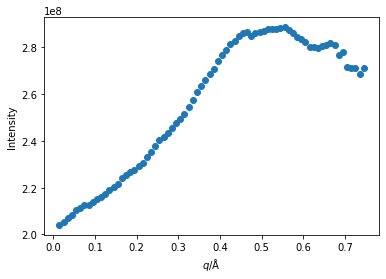

In [4]:
plt.plot(data_norm['qdcd_'], data_norm['adc2'], 'o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.show()

It can be seen that this information has been collected at a series of linearly-spaced, discrete points.
Therefore, such that the normalisation may be performed at the $q$-points collected in the experimental measurements we must interpolate, which is achieved with the `scipy.interpolate.splrep` function. 

In [5]:
itp = splrep(data_norm['qdcd_'], data_norm['adc2'])

This `itp` object will be used later in the reduction process. 

The next step is to loop through each of the reflectometry scans collected that make up a curve, remember that due to the changes in attenutation a full reflectometry curve typically contains 3-5 scans. 
In this work, five scans where performed and the files are called `refl_1.dat` to `refl_5.dat`. 

In [89]:
files = ['refl_{}.dat'.format(i) for i in range(1, 6)]

In [90]:
refl = refl_data.Profile(files, io.i07_dat_parser)

AttributeError: module 'islatu.refl_data' has no attribute 'Profile'

In [71]:
dat = []
for i in range(1, 6):
    dat.append(refl_data.ReflData('refl_{}.dat'.format(i), io.i07_dat_parser))

The above cell will read in each of the `.dat` files in turn and sore the information in a list named `dat`. 
With all of the `.dat` files read, the reduction can begin. 
Reflectometry data is collected at I07 as a series of detector images, like that shown below.

In [72]:
q = dat[-1].data['qdcd'][10]

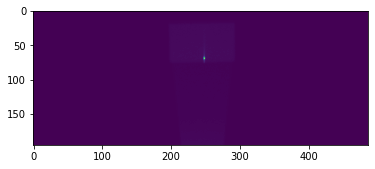

In [73]:
im = image.Image(dat[-1].data['file'][10])
plt.imshow(im.n)

The point in the middle of this image is the reflected intensity peak that we want to obtain, therefore it is necessary to crop this image down (to get rid of the unnecessary, blank pixels).

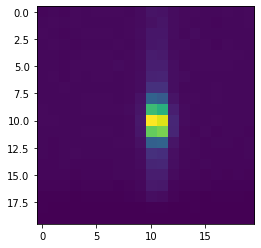

In [74]:
im.crop(cropping.crop_around_peak_2d)
plt.imshow(im.n)

Having reduce the size of the image and focused on the peak, we now need to perform a subtraction of the background signals. 
This signal can be seen if we reduce the dimensionality of the plot by summing along the y-axis of the image.

(0.0, 2000.0)

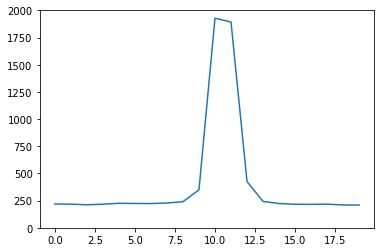

In [75]:
plt.plot(im.n.mean(axis=0))
plt.ylim(0, 2000)

Notice that the background level is around 250 counts.
It is necessary to remove this for our data to be accurate when modelling is applied later. 

The background subtraction is performed by fitting a two-dimensional Gaussian function, with some offset from the ordinate, to the image. 
The amount by which the fit is offset from the ordinate is then subtracted from each pixel of the image.

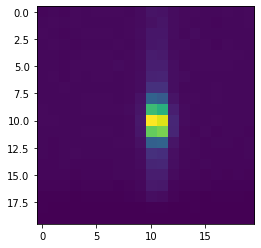

In [76]:
im.background_subtraction(background.fit_gaussian_2d)
plt.imshow(im.n)

The image above does not appear to have changed, but the background subtraction is visible when the dimensionality is reduced. 

(0.0, 2000.0)

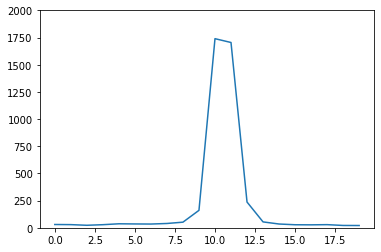

In [77]:
plt.plot(im.n.mean(axis=0))
plt.ylim(0, 2000)

The background level is stored in the `image.Image` object. 


In [78]:
print(im.bkg)

188+/-5


Above, we have performed the cropping and background subtraction on a single image, a single $q$-vector. 
However, it is necessary to perform this operation on all of the images, this is achieved through the `crop_and_bkg_sub` class method.
So to perform this process on each `.dat` file we run the following. 

In [80]:
for d in dat:
    d.crop_and_bkg_sub(cropping.crop_around_peak_2d, background.fit_gaussian_2d)

100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


This process can take some time.

The $q$-uncertainty can be assigned based on the shape of the two-dimensional Gaussian function which is fitted to the image.

In [81]:
for d in dat:
    d.q_uncertainty_from_pixel()

The image intensity is the summed to give the *unnormalised* reflected intensity, and associated uncertainties.

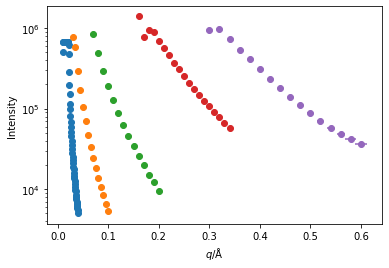

In [82]:
for d in dat:
    plt.errorbar(unp.nominal_values(d.q), 
                 unp.nominal_values(d.R), 
                 yerr=unp.std_devs(d.R),
                 xerr=unp.std_devs(d.q), 
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

There are now two normalisations to be performed on the individual scan, the first is due to the transmission of radiation. 
This means that when stitching is performed later, the data are already closer together in intensity so the stitching is more robust. 

In [83]:
for d in dat:
    d.transmission_normalisation()

You can see below the immediate improvement in the profile.

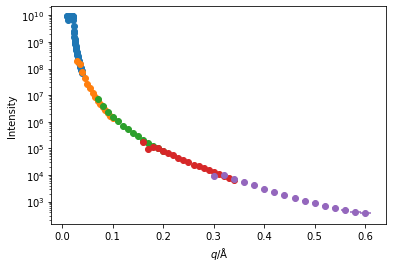

In [84]:
for d in dat:
    plt.errorbar(unp.nominal_values(d.q), 
                 unp.nominal_values(d.R), 
                 yerr=unp.std_devs(d.R),
                 xerr=unp.std_devs(d.q), 
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

The second correction is due to the DCD $q$-dependence mentioned previously. 
The interpolated line (`itp`) is fed into the analysis, using the `qdcd_normalisation` method. 

In [85]:
for d in dat:
    d.qdcd_normalisation(itp)

Finally, in the scan reduction, we perform the [footprint correction](https://doi.org/10.1107/S0021889807030403) which accounts for the sample being smaller than the beam footprint (due to the shallow angle).
Where the first argument is the beam width at half maximum, and the second argument is the sample size and uncertainty. 

In [87]:
for d in dat:
    d.footprint_correction(100e-6, ufloat(100e-3, 10e-3))

Finally we can plot our reduced scans.

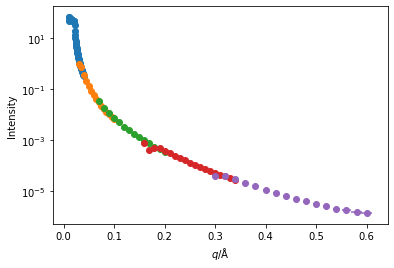

In [88]:
for d in dat:
    plt.errorbar(unp.nominal_values(d.q), 
                 unp.nominal_values(d.R), 
                 yerr=unp.std_devs(d.R),
                 xerr=unp.std_devs(d.q), 
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

Following the scan reduction, the $q$ and intensity data are combined as a s